In [1]:
import numpy as np
import random
import cv2 as cv
import pathlib, glob, os
import matplotlib.pyplot as plt
import time

import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.autograd import Variable

import albumentations as album

In [2]:
import sys
import re

def read_pfm(fpath, expected_identifier="Pf"):
    # PFM format definition: http://netpbm.sourceforge.net/doc/pfm.html
    
    def _get_next_line(f):
        next_line = f.readline().decode('utf-8').rstrip()
        # ignore comments
        while next_line.startswith('#'):
            next_line = f.readline().rstrip()
        return next_line
    
    with open(fpath, 'rb') as f:
        #  header
        identifier = _get_next_line(f)
        if identifier != expected_identifier:
            raise Exception('Unknown identifier. Expected: "%s", got: "%s".' % (expected_identifier, identifier))

        try:
            line_dimensions = _get_next_line(f)
            dimensions = line_dimensions.split(' ')
            width = int(dimensions[0].strip())
            height = int(dimensions[1].strip())
        except:
            raise Exception('Could not parse dimensions: "%s". '
                            'Expected "width height", e.g. "512 512".' % line_dimensions)

        try:
            line_scale = _get_next_line(f)
            scale = float(line_scale)
            assert scale != 0
            if scale < 0:
                endianness = "<"
            else:
                endianness = ">"
        except:
            raise Exception('Could not parse max value / endianess information: "%s". '
                            'Should be a non-zero number.' % line_scale)

        try:
            data = np.fromfile(f, "%sf" % endianness)
            data = np.reshape(data, (height, width))
            data = np.flipud(data)
            with np.errstate(invalid="ignore"):
                data *= abs(scale)
        except:
            raise Exception('Invalid binary values. Could not create %dx%d array from input.' % (height, width))

        return data

In [3]:
""" 1rst time load training data
#Datasets     
def ImageDataset(path_img, path_disp):
    imgs_path = path_img + "/*"
    paths = []
    for classes in glob.glob(imgs_path):
        class_name = classes.split("\\")[-1]#/
        paths.append(class_name)
    print(len(paths), paths)
    # Transforms for low resolution images and high resolution images
    X = [0, 64, 192, 256]

    for i in range (len(paths)):
        Img  = np.zeros((9, 512, 512, 3))
        GT   = np.zeros((9, 512, 512))
        Imgs = np.zeros((9, 256, 3))    
        GTs  = np.zeros((9, 256)) 
        
        for nb in range (9):
            Img[nb] = cv.imread(str('%s/%s/%s%03d.png') %(path_img, paths[i], "input_Cam", 36 + nb))#4 + nb*9
            GT[nb] = read_pfm(str('%s/%s/%s%03d.pfm') %(path_disp, paths[i], "gt_disp_lowres_Cam", 36 + nb))#4 + nb*9
            
        for idx in range (len(X)):  
            x_min=X[idx]
            for h in range(512):               
                for j in range (9): 
                    Imgs[j] = Img[j, h, x_min:x_min+256]
                    GTs[j]  = GT[j, h, x_min:x_min+256]
                    if j == 0:
                        cropped_Imgs = np.expand_dims(Imgs[j],0)
                        cropped_GTs = np.expand_dims(GTs[j],0)
                    else:
                        cropped_Imgs = np.concatenate((cropped_Imgs, np.expand_dims(Imgs[j],0)), axis=0)
                        cropped_GTs = np.concatenate((cropped_GTs, np.expand_dims(GTs[j],0)), axis=0)

                img_lr = (np.expand_dims(np.transpose(cropped_Imgs/255., (2, 0, 1)),0)).astype('float32')
                gt_lr  = (np.expand_dims(np.expand_dims(cropped_GTs,0),0)).astype('float32')

                if np.bitwise_and(np.bitwise_and(i==0, idx ==0), h==0):
                    Img_lr = img_lr
                    Gt_lr  = gt_lr
                else:
                    Img_lr =  np.concatenate((Img_lr, img_lr), axis=0)
                    Gt_lr  =  np.concatenate((Gt_lr, gt_lr), axis=0)
        
    return Img_lr, Gt_lr

x_train, y_train = ImageDataset("hci_dataset/additional", "hci_dataset/additional_depth_disp_all_views")
np.save('Ux_train.npy', x_train)
np.save('Uy_train.npy', y_train)
"""

"""
#Datasets     
def ImageDataset_V(path_img, path_disp):
    imgs_path = path_img + "/*"
    paths = []
    for classes in glob.glob(imgs_path):
        class_name = classes.split("\\")[-1]#/
        paths.append(class_name)
    print(len(paths), paths)
    # Transforms for low resolution images and high resolution images
    Y = [0, 64, 192, 256]

    for i in range (len(paths)):
        Img  = np.zeros((9, 512, 512, 3))
        GT   = np.zeros((9, 512, 512))
        Imgs = np.zeros((9, 256, 3))    
        GTs  = np.zeros((9, 256)) 
        
        for nb in range (9):
            Img[nb] = cv.imread(str('%s/%s/%s%03d.png') %(path_img, paths[i], "input_Cam", 4 + nb*9))#
            GT[nb]  = read_pfm(str('%s/%s/%s%03d.pfm') %(path_disp, paths[i], "gt_disp_lowres_Cam", 4 + nb*9))
            
        for idx in range (len(Y)):  
            y_min=Y[idx]
            for h in range(512):               
                for j in range (9): 
                    Imgs[j] = Img[j, y_min:y_min+256, h]
                    GTs[j]  = GT [j, y_min:y_min+256, h]
                    if j == 0:
                        cropped_Imgs = np.expand_dims(Imgs[j],0)
                        cropped_GTs = np.expand_dims(GTs[j],0)
                    else:
                        cropped_Imgs = np.concatenate((cropped_Imgs, np.expand_dims(Imgs[j],0)), axis=0)
                        cropped_GTs = np.concatenate((cropped_GTs, np.expand_dims(GTs[j],0)), axis=0)

                img_lr = (np.expand_dims(np.transpose(cropped_Imgs/255., (2, 0, 1)),0)).astype('float32')
                gt_lr  = (np.expand_dims(np.expand_dims(cropped_GTs,0),0)).astype('float32')

                if np.bitwise_and(np.bitwise_and(i==0, idx ==0), h==0):
                    Img_lr = img_lr
                    Gt_lr  = gt_lr
                else:
                    Img_lr =  np.concatenate((Img_lr, img_lr), axis=0)
                    Gt_lr  =  np.concatenate((Gt_lr, gt_lr), axis=0)
        
    return Img_lr, Gt_lr

x_train, y_train = ImageDataset_V("hci_dataset/additional", "hci_dataset/additional_depth_disp_all_views")
np.save('Ux_train_1.npy', x_train)
np.save('Uy_train_1.npy', y_train)
"""

'\n#Datasets     \ndef ImageDataset_V(path_img, path_disp):\n    imgs_path = path_img + "/*"\n    paths = []\n    for classes in glob.glob(imgs_path):\n        class_name = classes.split("\\")[-1]#/\n        paths.append(class_name)\n    print(len(paths), paths)\n    # Transforms for low resolution images and high resolution images\n    Y = [0, 64, 192, 256]\n\n    for i in range (len(paths)):\n        Img  = np.zeros((9, 512, 512, 3))\n        GT   = np.zeros((9, 512, 512))\n        Imgs = np.zeros((9, 256, 3))    \n        GTs  = np.zeros((9, 256)) \n        \n        for nb in range (9):\n            Img[nb] = cv.imread(str(\'%s/%s/%s%03d.png\') %(path_img, paths[i], "input_Cam", 4 + nb*9))#\n            GT[nb]  = read_pfm(str(\'%s/%s/%s%03d.pfm\') %(path_disp, paths[i], "gt_disp_lowres_Cam", 4 + nb*9))\n            \n        for idx in range (len(Y)):  \n            y_min=Y[idx]\n            for h in range(512):               \n                for j in range (9): \n                

In [4]:
#Datasets
batch_size = 256
data_train = torch.utils.data.TensorDataset(torch.from_numpy(np.concatenate((np.load('Ux_train.npy'), np.load('Ux_train_1.npy')), axis=0)), torch.from_numpy(np.concatenate((np.load('Uy_train.npy'), np.load('Uy_train_1.npy')), axis=0)))
trainloader = DataLoader(data_train, batch_size = batch_size, shuffle=True, drop_last=True)
print(len(trainloader))

256


In [5]:
#Datasets
class ImageDataset_T(Dataset):
    def __init__(self, path_img, path_disp):
        self.Img_path = path_img
        self.Disp_path = path_disp
        
        self.imgs_path = path_img + "/*"
        self.paths = []
        for classes in glob.glob(self.imgs_path):
            class_name = classes.split("\\")[-1]#\\
            self.paths.append(class_name)
        print(len(self.paths), self.paths)
            
        # Transforms for low resolution images and high resolution images
        self.X = 128
    
    def __len__(self):
        return len(self.paths*8)
    
    def __getitem__(self, idxx):#

        idx = idxx//8
        x_min=self.X

        aug = np.random.randint(0,2)
        
        for i in range(9):
            if aug == 0:  
                img = cv.imread(str('%s/%s/%s%03d.png') %(self.Img_path, self.paths[idx], "input_Cam", 36 + i))
                disp = read_pfm(str('%s/%s/%s%03d.pfm') %(self.Disp_path, self.paths[idx], "gt_disp_lowres_Cam", 36 + i))

                cropped_img  = img [(idxx%8)*64, x_min:x_min+256]
                cropped_disp = disp[(idxx%8)*64, x_min:x_min+256]
            else:
                img = cv.imread(str('%s/%s/%s%03d.png') %(self.Img_path, self.paths[idx], "input_Cam", 4 + 9*i))
                disp = read_pfm(str('%s/%s/%s%03d.pfm') %(self.Disp_path, self.paths[idx], "gt_disp_lowres_Cam", 4 + 9*i))

                cropped_img  = img [x_min:x_min+256, (idxx%8)*64]
                cropped_disp = disp[x_min:x_min+256, (idxx%8)*64]
            
            if i==0:
                cropped_Imgs = np.expand_dims(cropped_img,0)
                cropped_Disps = np.expand_dims(cropped_disp,0)
            else:
                cropped_Imgs =  np.concatenate((cropped_Imgs, np.expand_dims(cropped_img,0)), axis=0)
                cropped_Disps =  np.concatenate((cropped_Disps, np.expand_dims(cropped_disp,0)), axis=0)
                
        
        img_lr = (np.transpose(cropped_Imgs/255., (2, 0, 1))).astype('float32')
        gt_lr  = (np.expand_dims(cropped_Disps,0)).astype('float32')
        
        return {"lr": torch.from_numpy(img_lr), "GT": torch.from_numpy(gt_lr)}


batch_size = 64
data_test = ImageDataset_T("hci_dataset/additional", "hci_dataset/additional_depth_disp_all_views")
testloader = DataLoader(data_test, batch_size = batch_size, shuffle=False, drop_last=True)
print(len(testloader))

16 ['antinous', 'boardgames', 'dishes', 'greek', 'kitchen', 'medieval2', 'museum', 'pens', 'pillows', 'platonic', 'rosemary', 'table', 'tomb', 'tower', 'town', 'vinyl']
2


Images


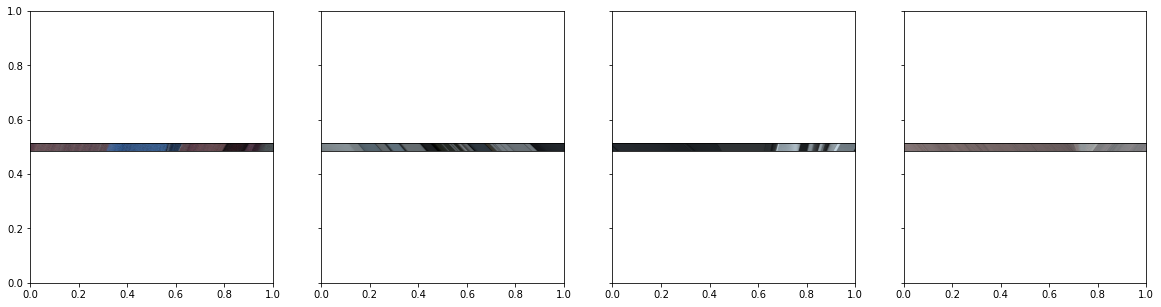

GT Disparity


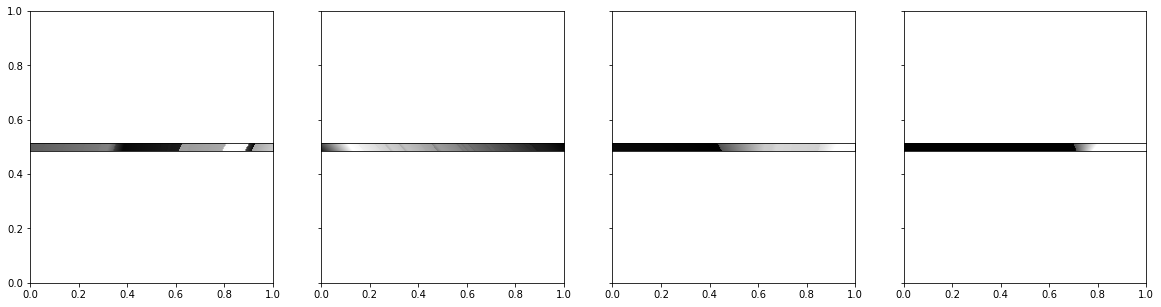

In [6]:
def imshow_img(img):
    plt.imshow(np.transpose(img, (1, 2, 0)), cmap = "gray") 

def imshow_disp(img):
    plt.imshow(np.squeeze(img), cmap = "gray") 

#Batch of train images
dataiter = iter(trainloader)
imgs = dataiter.next()
images, GT = imgs#["lr"], imgs["GT"]

#GT Images
print("Images")
fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(20,5))
for idx in np.arange(4):
    ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
    imshow_img(images[idx])
plt.show()

print("GT Disparity")
fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(20,5))
for idx in np.arange(4):
    ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
    imshow_disp(GT[idx])
plt.show()

In [7]:
class conv(nn.Sequential):
    def __init__(self, in_ch, out_ch):
        super().__init__() #super() method lets you access methods from a parent class from within a child class
        self.add_module("Conv_1", nn.Conv2d(in_ch, out_ch, kernel_size=3, padding='same'))
        self.add_module("BN_1", nn.BatchNorm2d(out_ch))
        self.add_module("RELU_1", nn.ReLU())
        
class conv_block(nn.Sequential):
    def __init__(self, in_ch, out_ch):
        super().__init__() #super() method lets you access methods from a parent class from within a child class
        self.add_module("Conv_1", nn.Conv2d(in_ch, out_ch, kernel_size=3, padding='same'))
        self.add_module("BN_1", nn.BatchNorm2d(out_ch))
        self.add_module("RELU_1", nn.ReLU())
        #2nd layer 
        self.add_module("Conv_2",nn.Conv2d(out_ch, out_ch, kernel_size=3, padding='same'))
        self.add_module("BN_2", nn.BatchNorm2d(out_ch))
        self.add_module("RELU_2", nn.ReLU())

In [8]:
class encoder_block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv_x2 = conv_block(in_ch, out_ch)
        self.MaxPool = nn.MaxPool2d((1,2), stride=(1,2))
    def forward(self, x):
        x = self.conv_x2(x)
        p = self.MaxPool(x)
        return x, p
    
class decoder_block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.convT = nn.ConvTranspose2d(in_ch, out_ch, (1,2), (1,2))
        self.conv_x2 = conv_block(out_ch*2, out_ch)
    def forward(self, x, skip_features):
        x = self.convT(x)
        x = torch.cat((x, skip_features), dim=1)
        x = self.conv_x2(x)
        return x

In [9]:
class Unet_3L(nn.Module):
    def __init__(self, in_ch=3):
        super().__init__()
        self.encod_1 = encoder_block(in_ch, 32)
        self.encod_2 = encoder_block(32, 64)
        self.encod_3 = encoder_block(64, 128)
        #self.encod_4 = encoder_block(128, 256)
        
        #self.encod_5 = encoder_block(256, 512)
        #self.conv = conv(512, 1024)     
        #self.decod_1 = decoder_block(1024, 512)
        
        self.conv = conv(128, 256)
        
        #self.decod_2 = decoder_block(512, 256)
        self.decod_3 = decoder_block(256, 128)
        self.decod_4 = decoder_block(128, 64)
        self.decod_5 = decoder_block(64, 32)
        
        self.convf = nn.Conv2d(32, 1, kernel_size=3, padding='same')      
    def forward(self, x):
        x1, p1 = self.encod_1(x)
        x2, p2 = self.encod_2(p1)
        x3, p3 = self.encod_3(p2)
    
        b1 = self.conv(p3)
        
        d1 = self.decod_3(b1, x3)
        d2 = self.decod_4(d1, x2)
        d3 = self.decod_5(d2, x1)
        
        xf = self.convf(d3)
        return xf
    
#Instantiate the model
model = Unet_3L()

In [10]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)

summary(model,(3,9,256))

Tensor = torch.cuda.FloatTensor if device == 'cuda:0' else torch.FloatTensor

#Loss function
criterion = torch.nn.L1Loss()

# Load pretrained models 
load_pretrained_models = True
model_path = "Unet_model_3L_best.pth"
if load_pretrained_models:
    model.load_state_dict(torch.load(model_path,map_location=device))

cuda:0
Layer (type:depth-idx)                   Output Shape              Param #
├─encoder_block: 1-1                     [-1, 32, 9, 256]          --
|    └─conv_block: 2-1                   [-1, 32, 9, 256]          --
|    |    └─Conv2d: 3-1                  [-1, 32, 9, 256]          896
|    |    └─BatchNorm2d: 3-2             [-1, 32, 9, 256]          64
|    |    └─ReLU: 3-3                    [-1, 32, 9, 256]          --
|    |    └─Conv2d: 3-4                  [-1, 32, 9, 256]          9,248
|    |    └─BatchNorm2d: 3-5             [-1, 32, 9, 256]          64
|    |    └─ReLU: 3-6                    [-1, 32, 9, 256]          --
|    └─MaxPool2d: 2-2                    [-1, 32, 9, 128]          --
├─encoder_block: 1-2                     [-1, 64, 9, 128]          --
|    └─conv_block: 2-3                   [-1, 64, 9, 128]          --
|    |    └─Conv2d: 3-7                  [-1, 64, 9, 128]          18,496
|    |    └─BatchNorm2d: 3-8             [-1, 64, 9, 128]          128

In [11]:
val_min = 1

#Optimizer
lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)#
#optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.95)

start_time = time.time()

train_losses=[]
for epoch in range(1,1):  # loop over the dataset multiple times
    model.train()
    train_loss = 0.0
    for i, data in enumerate(trainloader):#(trainloader,0)
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data#["lr"], data["GT"]
        inputs.cuda()
        labels.cuda()

        inputs = torch.autograd.Variable(inputs.type(Tensor))
        labels = torch.autograd.Variable(labels.type(Tensor))
        
        optimizer.zero_grad()

        output = model(inputs)
    
        loss = criterion(output, labels)
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss = train_loss/len(trainloader)
    # append training loss
    train_losses.append(train_loss)
    
    #validation 
    model.eval()
    val_losses=0
    with torch.no_grad():
        #Batch of test images
        for j, imgs in enumerate(testloader):
            images, GT = imgs["lr"], imgs["GT"]
            #Sample outputs
            output = model(images.type(Tensor))

            val_loss = criterion(output, GT.type(Tensor))
            val_losses += val_loss.item()

        val_losses = val_losses/len(testloader)
        
    print('Epoch: {} \tTraining Loss: {:.5f}, \tValidation Loss: {:.5f}'.format(epoch, train_loss, val_losses))
    if val_losses < val_min:
        torch.save(model.state_dict(), "Unet_model_3LA_best.pth")
        val_min = val_losses

    # Save model checkpoints
    if (epoch)%5 == 0:
        torch.save(model.state_dict(), "Unet_model.pth")
        print("save model!")
"""
        #save model
        torch.save(model.state_dict(), f"Unet_model_5L_{epoch+140}.pth")
        print(f"save model: {epoch+140}")
"""
    
print('Finished Training')
print("--- %s seconds ---" % (time.time() - start_time))

Finished Training
--- 0.0009961128234863281 seconds ---


In [12]:
def Valid(data_img, data_disp, X): 
    model.eval()
    with torch.no_grad():
        Img = np.zeros((9, 512, 512, 3))
        GT = np.zeros((9, 512, 512))
        Disparity_lr = np.zeros((512, 9, 512))
        GTs = np.zeros((512, 9, 512))
        
        for i in range(9):
            Img[i] = cv.imread(str('%s/%s%03d.png') %(data_img, "input_Cam", 36 + i))
            GT[i] = read_pfm(str('%s/%s%03d.pfm') %(data_disp, "gt_disp_lowres_Cam", 36 + i))

        for ii in range(2):
            x_min = X[ii]
            for h in range(4//2):               
                img_lr = torch.from_numpy(np.zeros((128*2, 3, 9, 256)))
                for hh in range(128*2):
                    Imgs = np.zeros((9, 256, 3))    
                    for j in range (9): 
                        Imgs[j] = Img[j, hh+h*128*2, x_min:x_min+256]
                        if j == 0:
                            cropped_Imgs = np.expand_dims(Imgs[j],0)
                        else:
                            cropped_Imgs = np.concatenate((cropped_Imgs, np.expand_dims(Imgs[j],0)), axis=0)
                            
                    img_lr[hh] = torch.from_numpy(np.expand_dims(cropped_Imgs,0)).permute(0, 3, 1, 2)
                    
                cropped_Imgs_tensor = img_lr/255.0

                #Sample outputs
                output = model(cropped_Imgs_tensor.type(Tensor))

                output = output.cpu()
                output = output.view(128*2, 1, 9, 256)
                output = output.detach().numpy()

                Disparity_lr[h*128*2:(h+1)*128*2,:,ii*256:(ii+1)*256] = np.squeeze(output)
                GTs         [h*128*2:(h+1)*128*2,:,ii*256:(ii+1)*256] = np.transpose(GT[:,h*128*2:(h+1)*128*2,ii*256:(ii+1)*256], (1,0,2))

        for fi in range(4,5):   
            fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10,5))
            ax_1 = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
            plt.imshow(GTs[:,fi,:], cmap ='gray')
            ax_2 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
            plt.imshow(Disparity_lr[:,fi,:], cmap ='gray')
            
            fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10,5))
            ax_1 = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
            plt.imshow(GTs[:,fi,:]-Disparity_lr[:,fi,:], cmap ='gray')
            ax_2 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
            plt.imshow(np.abs(GTs[:,fi,:]-Disparity_lr[:,fi,:])<0.09, cmap ='gray')
            plt.show()

            print(np.mean(np.abs(GTs[:,fi,:]-Disparity_lr[:,fi,:])<0.09)*100)
            print(np.mean(np.abs(GTs[:,fi,:]-Disparity_lr[:,fi,:])))

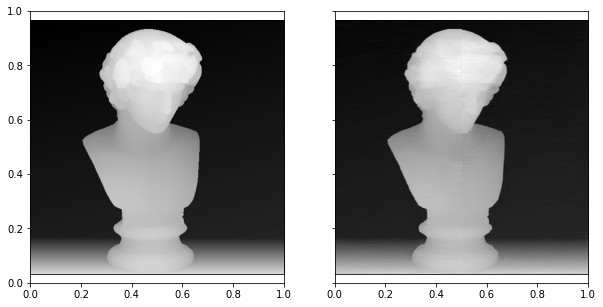

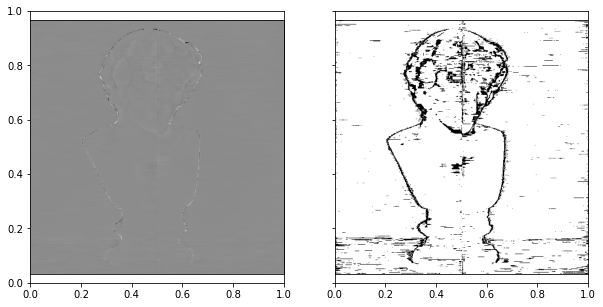

93.37158203125
0.04055851300923665


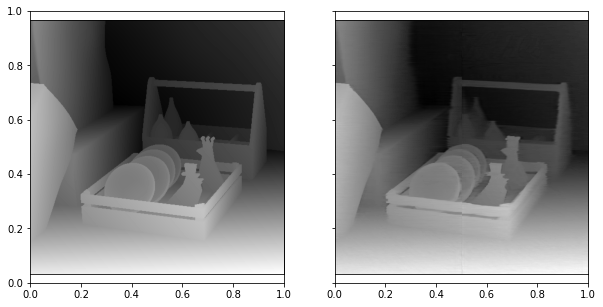

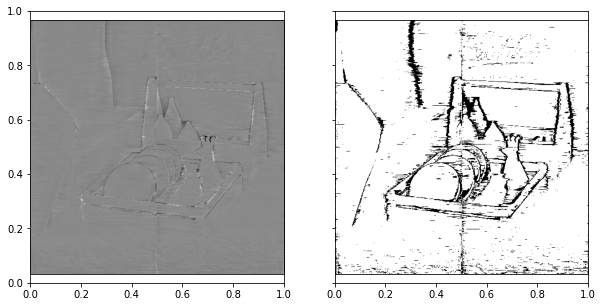

91.4825439453125
0.04247300321159003


In [13]:
X = [0, 256]

data_img = "hci_dataset/additional/antinous"
data_disp = "hci_dataset/additional_depth_disp_all_views/antinous"
Valid(data_img, data_disp, X)

data_img = "hci_dataset/additional/dishes"
data_disp = "hci_dataset/additional_depth_disp_all_views/dishes"
Valid(data_img, data_disp, X)

In [14]:
def Test_All(data_img, Y): 
    Img_1 = np.zeros((9, 512, 512, 3))
    Disparity_lr_1 = np.zeros((512, 9, 512))
    Img_2 = np.zeros((9, 512, 512, 3))
    Disparity_lr_2 = np.zeros((512, 9, 512))
        
    model.eval()
    with torch.no_grad():
        
        for i in range(9):
            Img_1[i] = cv.imread(str('%s/%s%03d.png') %(data_img, "input_Cam", 4 + 9*i))
            Img_2[i] = cv.imread(str('%s/%s%03d.png') %(data_img, "input_Cam", 36 + i))

        for ii in range(2):
            y_min = Y[ii]
            for h in range(4//2):               
                img_lr = torch.from_numpy(np.zeros((128*2, 3, 9, 256)))
                for hh in range(128*2):
                    Imgs = np.zeros((9, 256, 3))    
                    for j in range (9): 
                        Imgs[j] = Img_1[j, y_min:y_min+256, hh+h*128*2]
                        if j == 0:
                            cropped_Imgs = np.expand_dims(Imgs[j],0)
                        else:
                            cropped_Imgs = np.concatenate((cropped_Imgs, np.expand_dims(Imgs[j],0)), axis=0)
                            
                    img_lr[hh] = torch.from_numpy(np.expand_dims(cropped_Imgs,0)).permute(0, 3, 1, 2)
                    
                cropped_Imgs_tensor = img_lr/255.0

                #Sample outputs
                output = model(cropped_Imgs_tensor.type(Tensor))

                output = output.cpu()
                output = output.view(128*2, 1, 9, 256)
                output = output.detach().numpy()

                Disparity_lr_1[h*128*2:(h+1)*128*2,:,ii*256:(ii+1)*256] = np.squeeze(output)
                
        for ii in range(2):
            y_min = Y[ii]
            for h in range(4//2):               
                img_lr = torch.from_numpy(np.zeros((128*2, 3, 9, 256)))
                for hh in range(128*2):
                    Imgs = np.zeros((9, 256, 3))    
                    for j in range (9): 
                        Imgs[j] = Img_2[j, hh+h*128*2, y_min:y_min+256]
                        if j == 0:
                            cropped_Imgs = np.expand_dims(Imgs[j],0)
                        else:
                            cropped_Imgs = np.concatenate((cropped_Imgs, np.expand_dims(Imgs[j],0)), axis=0)
                            
                    img_lr[hh] = torch.from_numpy(np.expand_dims(cropped_Imgs,0)).permute(0, 3, 1, 2)
                    
                cropped_Imgs_tensor = img_lr/255.0

                #Sample outputs
                output = model(cropped_Imgs_tensor.type(Tensor))

                output = output.cpu()
                output = output.view(128*2, 1, 9, 256)
                output = output.detach().numpy()

                Disparity_lr_2[h*128*2:(h+1)*128*2,:,ii*256:(ii+1)*256] = np.squeeze(output)

        for fi in range(4,5):         
            if fi==4:
                GT = read_pfm(str('%s/%s.pfm') %(data_img, "gt_disp_lowres"))
                
                fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10, 5))
                ax_1 = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
                plt.imshow(GT, cmap ='gray')
                ax_2 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
                plt.imshow((Disparity_lr_1[:,fi,:].T+Disparity_lr_2[:,fi,:])/2., cmap ='gray')
                
                fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10, 5))
                ax_1 = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
                plt.imshow(GT-(Disparity_lr_1[:,fi,:].T+Disparity_lr_2[:,fi,:])/2., cmap ='gray')
                ax_2 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
                plt.imshow(np.abs(GT-(Disparity_lr_1[:,fi,:].T+Disparity_lr_2[:,fi,:])/2.)<0.07, cmap ='gray')
                plt.show()

                print(np.mean(np.abs(GT-(Disparity_lr_1[:,fi,:].T+Disparity_lr_2[:,fi,:])/2.)<0.07)*100)
                print(np.mean(np.abs(GT-(Disparity_lr_1[:,fi,:].T+Disparity_lr_2[:,fi,:])/2.)))
            else:
                fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(10, 5))
                axes = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
                plt.imshow((Disparity_lr_1[:,fi,:].T+Disparity_lr_2[:,fi,:])/2., cmap ='gray')

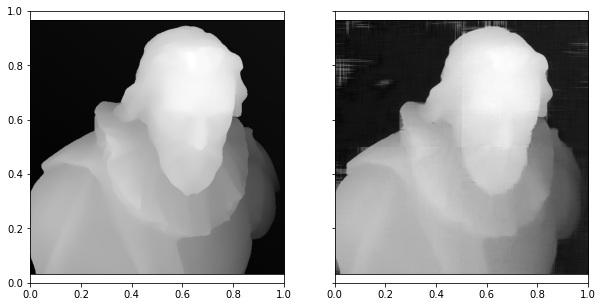

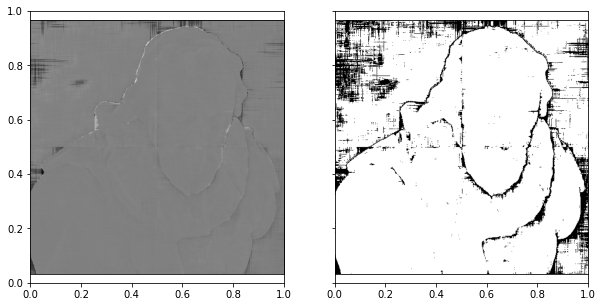

89.65492248535156
0.04190149941224459


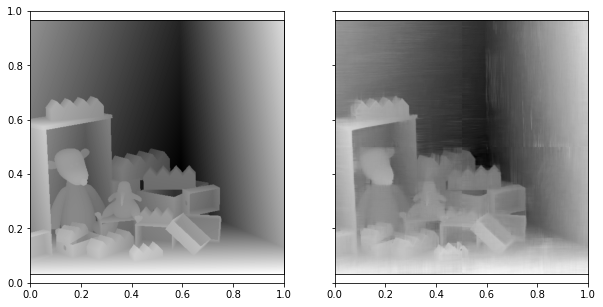

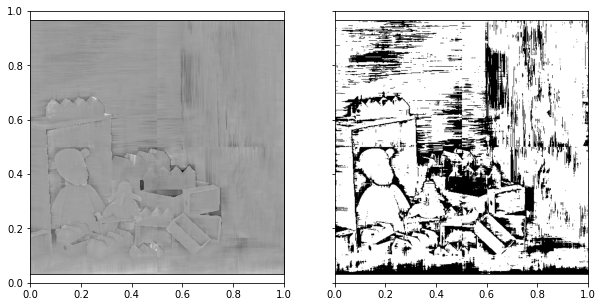

75.39634704589844
0.05874372244359829


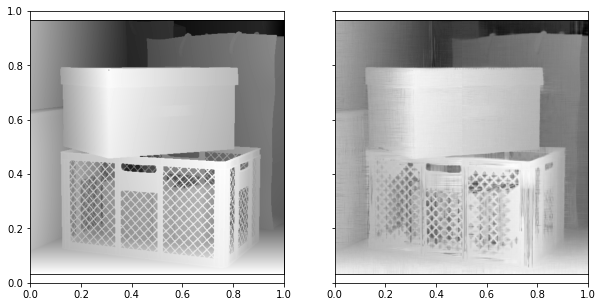

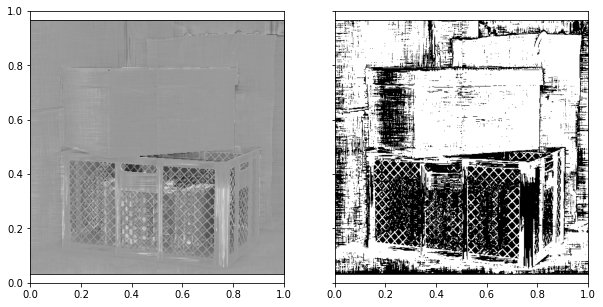

64.67666625976562
0.13119879217660113


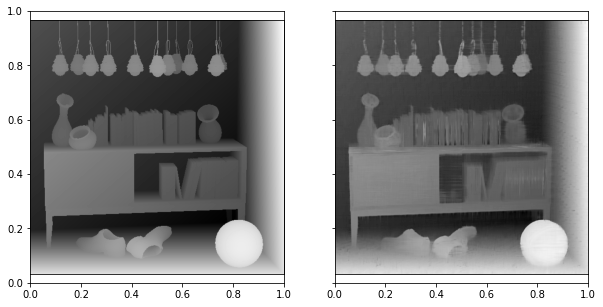

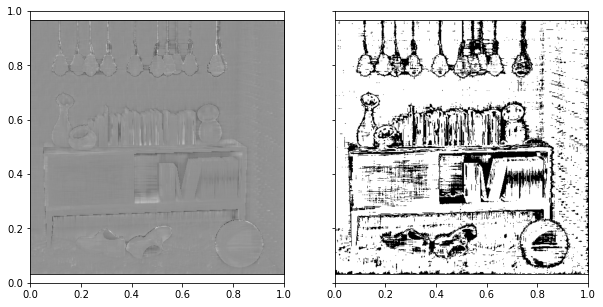

79.85343933105469
0.0573831616527832


In [15]:
Y = [0, 256]

data_img = "hci_dataset/training/cotton"
Test_All(data_img, Y)

data_img = "hci_dataset/training/dino"
Test_All(data_img, Y)

data_img = "hci_dataset/training/boxes"
Test_All(data_img, Y)

data_img = "hci_dataset/training/sideboard"
Test_All(data_img, Y)

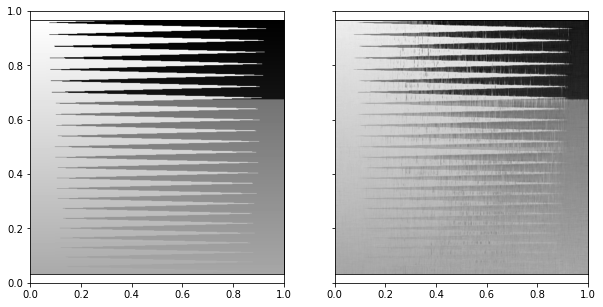

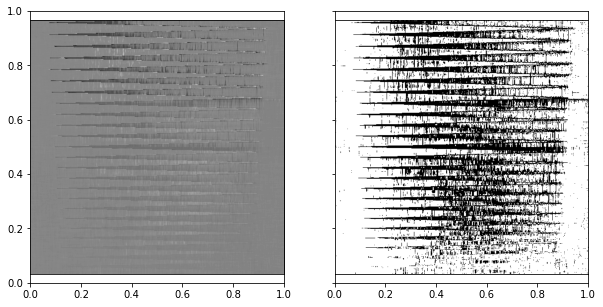

69.43855285644531
0.09584948891791714


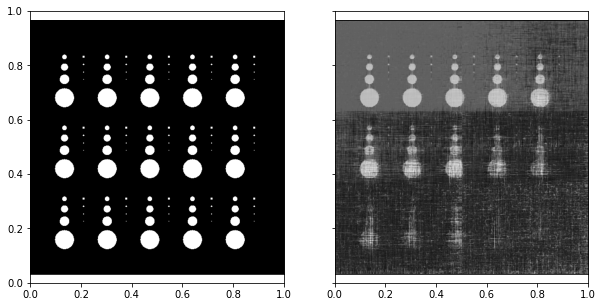

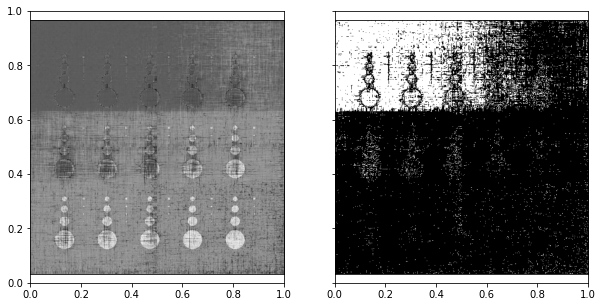

20.197677612304688
0.5573008555720271


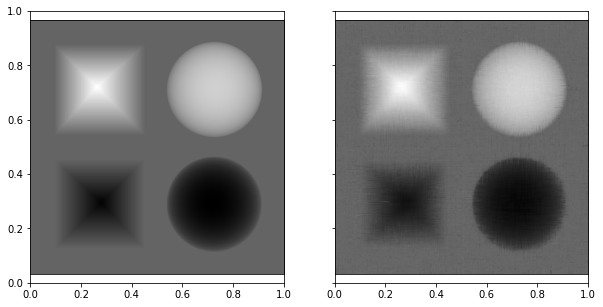

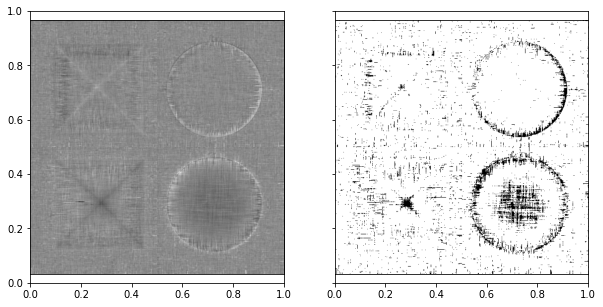

94.06318664550781
0.026308308815565694


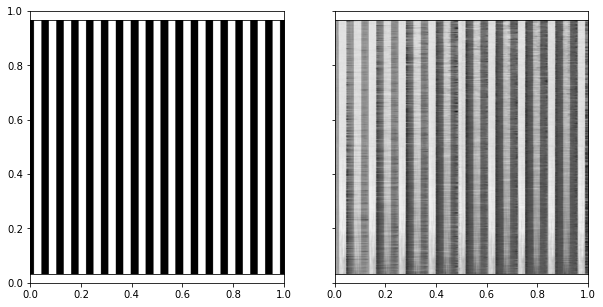

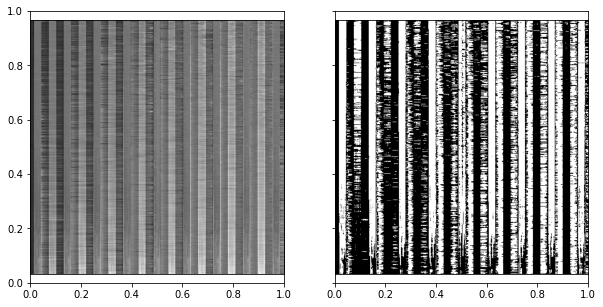

47.754669189453125
0.12885002776180698


In [16]:
data_img = "hci_dataset/stratified/backgammon"
Test_All(data_img, Y)

data_img = "hci_dataset/stratified/dots"
Test_All(data_img, Y)

data_img = "hci_dataset/stratified/pyramids"
Test_All(data_img, Y)

data_img = "hci_dataset/stratified/stripes"
Test_All(data_img, Y)